In [1]:
%matplotlib inline


# True positive proportions in fMRI clusters using Notip

This script showcases the so-called Notip procedure [1], in
which the proportion of true discoveries in arbitrary clusters is estimated.
The clusters can be defined from the input image, i.e. in a circular way, as
the error control accounts for arbitrary cluster selection.


In [2]:
pip install notip -q


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Fetch dataset
We download a list of left vs right button press maps from the so-called localizer dataset [2]. Concretely, these maps represent the difference in brain activation when subjects are instructed (via auditory cue) to press a button using their left vs their right hand. Note that we fetch individual t-maps that represent the BOLD activity estimate divided by the uncertainty about this estimate.

In [3]:
from nilearn.datasets import fetch_localizer_contrasts
import numpy as np

n_subjects = 30
data = fetch_localizer_contrasts(
    ["left vs right button press"],
    n_subjects,
    get_tmaps=True,
    legacy_format=False,
)

Let's visualize the input data:

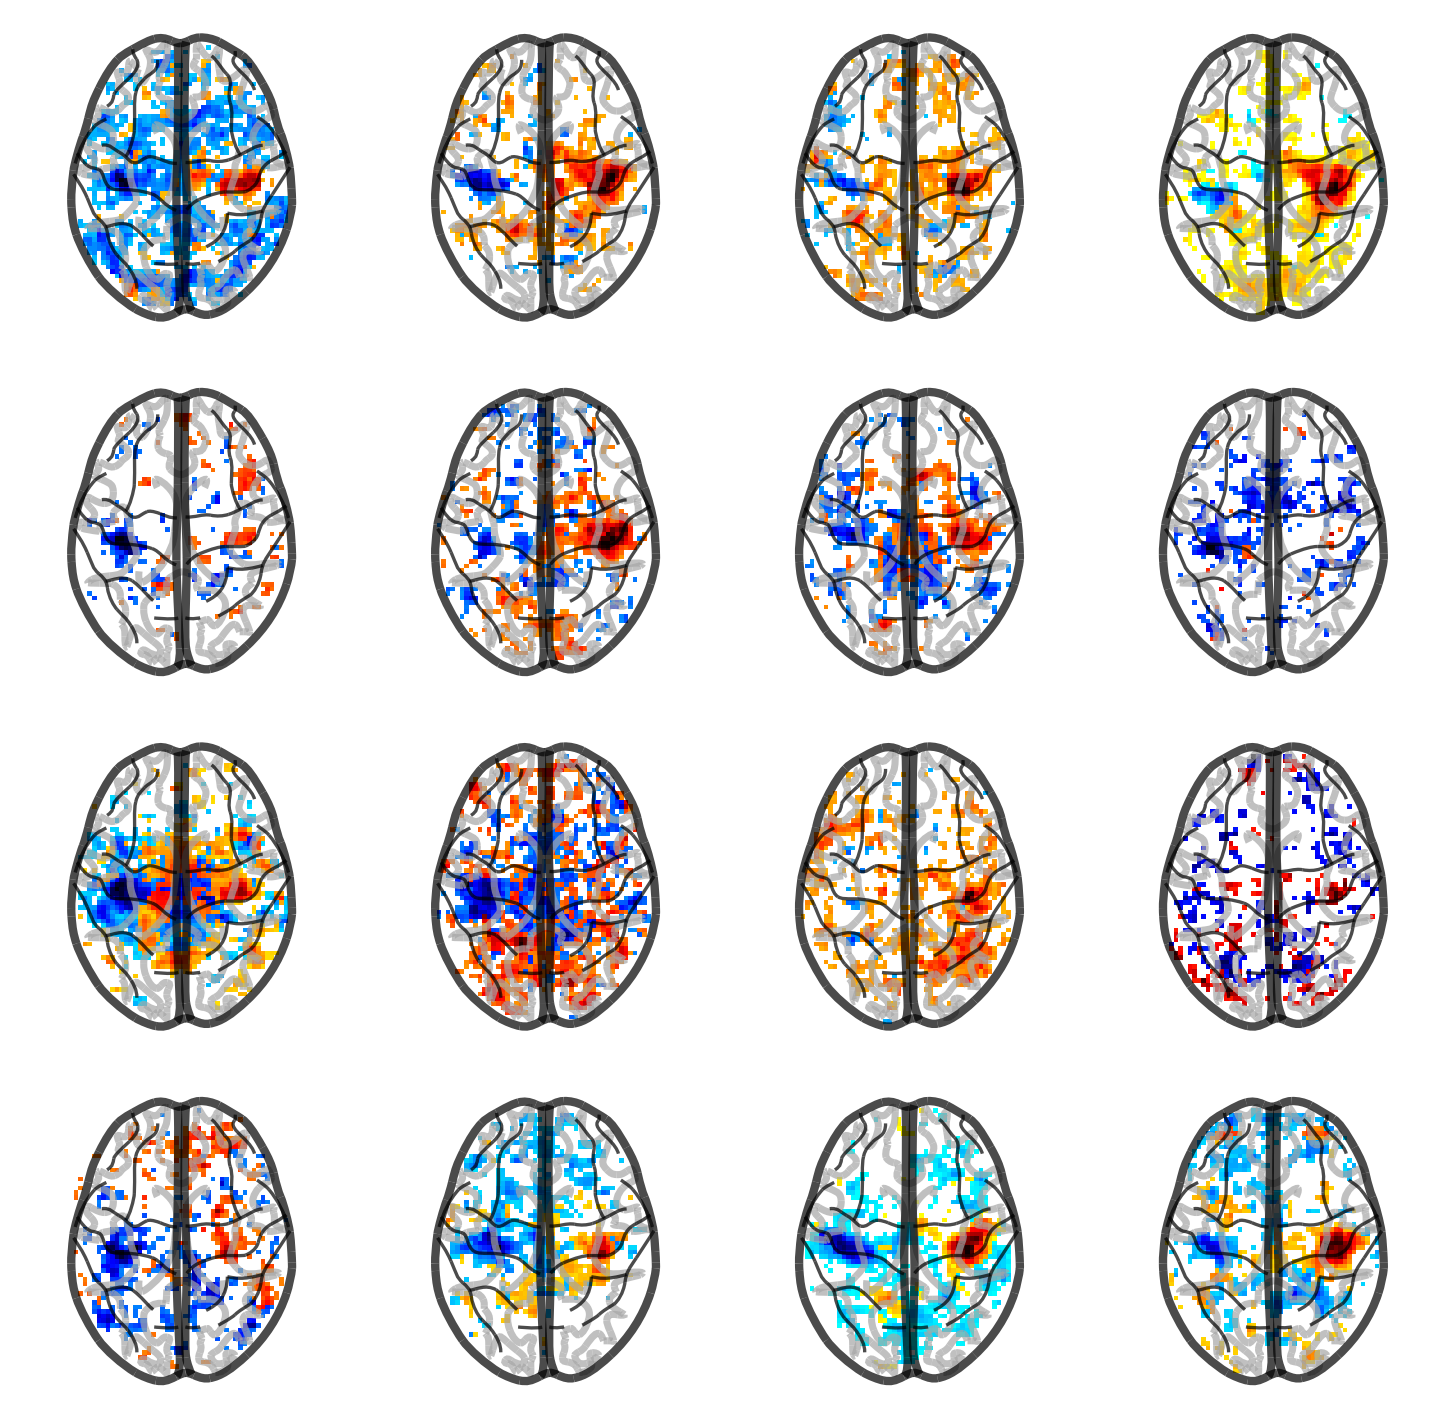

In [4]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_glass_brain
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6), dpi=300)
# we only look at 16 subjects
for cidx, tmap in enumerate(data['tmaps'][:16]):
    plot_glass_brain(
        tmap,
        colorbar=False,
        threshold=2.0,
        axes=axes[int(cidx / 4), int(cidx % 4)],
        plot_abs=False,
        annotate=False,
        display_mode='z')

To extract signal from these images, we need a masker:

In [5]:
from nilearn.maskers import NiftiMasker
smoothing_fwhm = 8.0
nifti_masker = NiftiMasker(smoothing_fwhm=smoothing_fwhm)

In [6]:
fmri_input = nifti_masker.fit_transform(data["tmaps"])

In [7]:
print(fmri_input.shape)

(30, 75019)


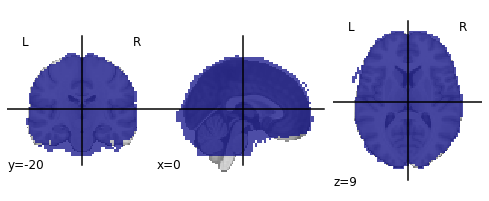

In [11]:
# Note that the masker has automatically computed a brain mask
# One can take a look at it
from nilearn.plotting import plot_roi
plot_roi(nifti_masker.mask_img_)

We have extracted the values of 75019 voxels from 30 images.

### Computing True Discovery Proportion (TDP) lower bounds on data-derived clusters

First, we need to compute a statistical map from the input data. This is done via a t-test, performed for each voxel.

In [21]:
from scipy import stats
from scipy.stats import norm

# Let's run a one-sample t test on these data
stats_, p_values = stats.ttest_1samp(fmri_input, 0, alternative='greater')

# Let's z-transform these p-values into z-values
# z_vals_ = norm.isf(p_values)

# Let's make this an image by using the inverse_transform method of the masker
stat_map = nifti_masker.inverse_transform(stats_)

Let us visualise the resulting z_map:

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



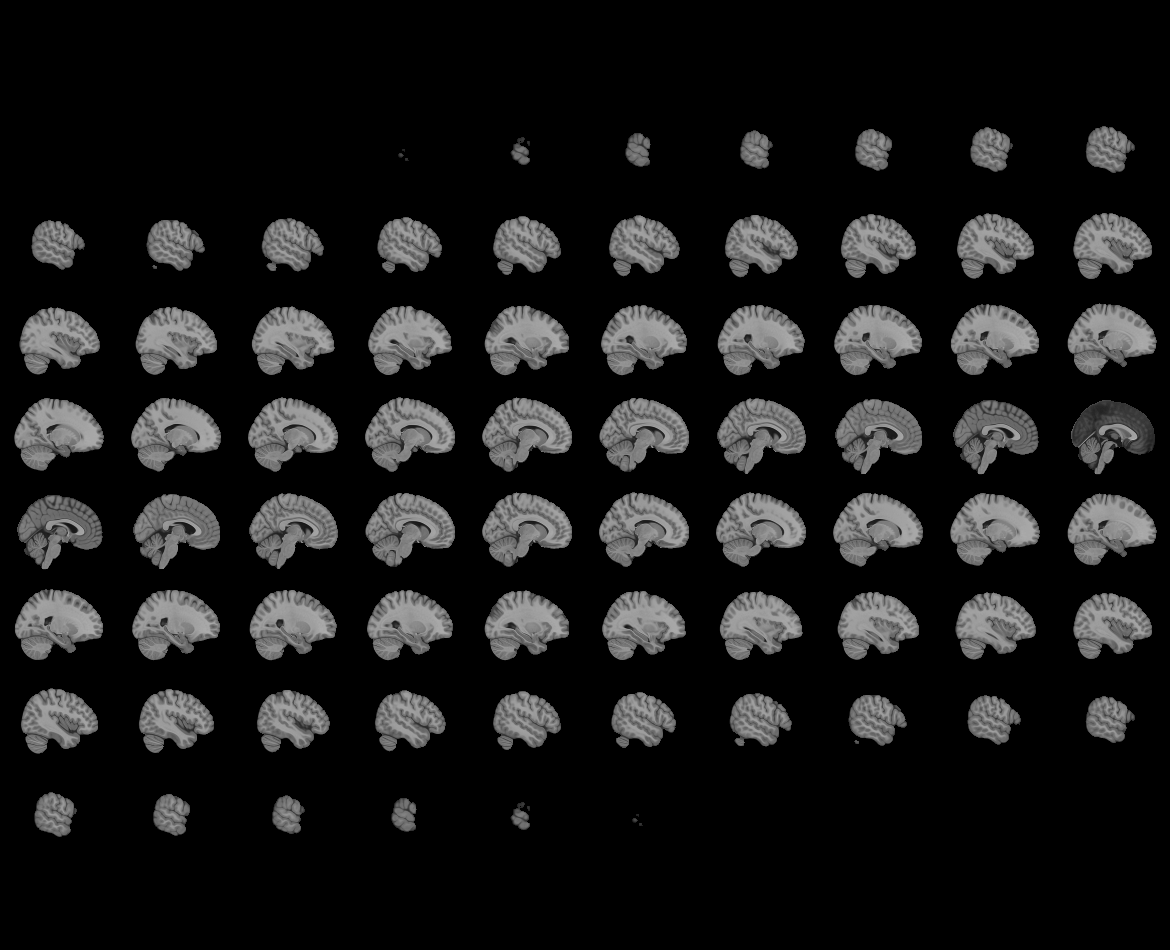
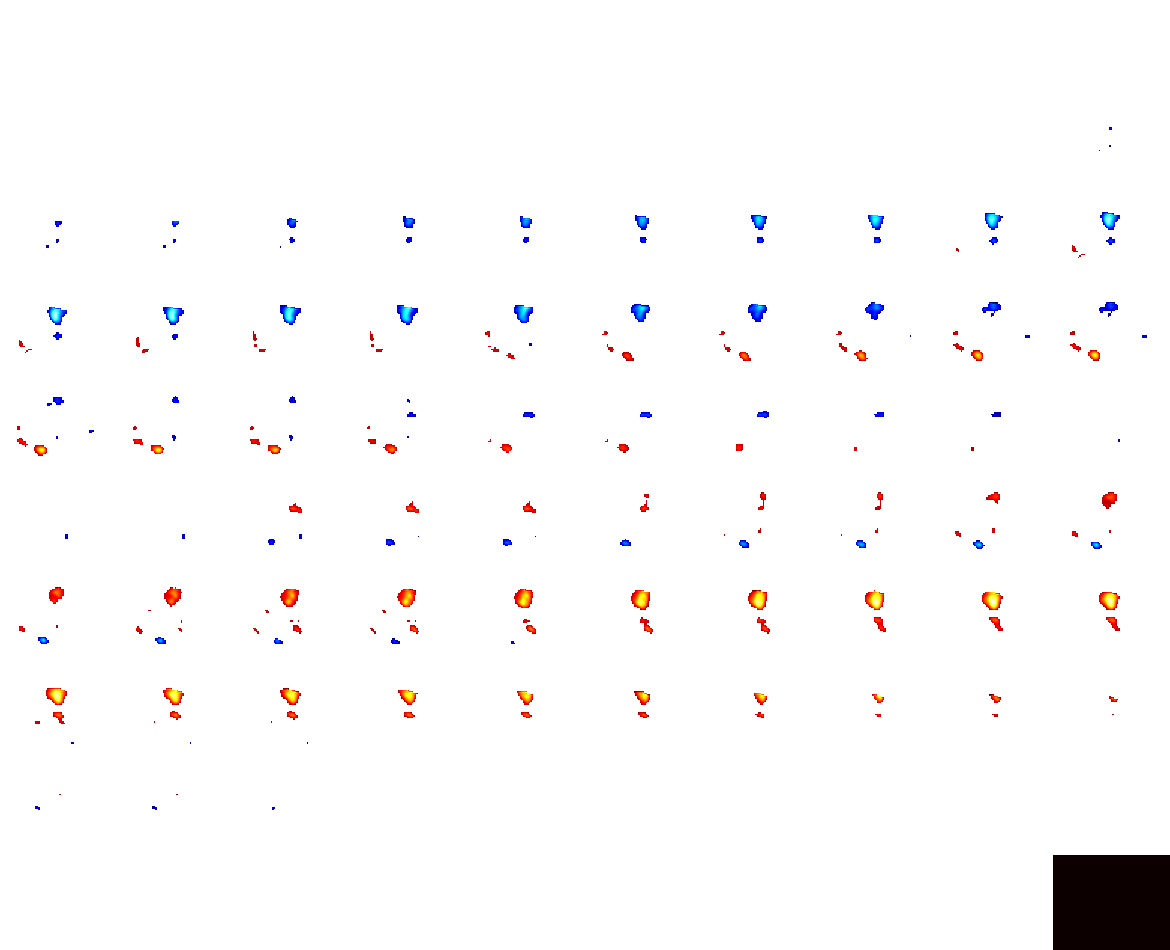

In [23]:
from nilearn.plotting import view_img
stat_threshold = 3.5
view_img(stat_map, 
         title='Group-level t-map',
         threshold=stat_threshold,
         colorbar=True)

We can now use Notip to compute TDP lower bounds on clusters exceeding a z-value threshold. We set this threshold to 3.5.

In [12]:
from notip.posthoc_fmri import get_clusters_table_TDP_1samp
get_clusters_table_TDP_1samp(
    z_map,
    fmri_input,
    n_permutations=200,
    stat_threshold=stat_threshold,
    methods=['Notip'])
# todo: remove z_map
# todo: create get_clusters_table_TDP_ind

/home/ablain/.local/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Cluster ID     X     Y     Z Peak Stat Cluster Size (mm3) TDP (Notip)
0           1  39.0 -21.0  54.0      7.33              30294        0.86
1           2 -39.0 -24.0  57.0      7.11              24624        0.83
2           3 -18.0 -51.0 -24.0      6.41               6264        0.60
3           4  21.0 -48.0 -24.0      6.08               3888        0.57
4           5  30.0  -9.0   0.0      5.15               5481        0.48
5          5a  45.0 -18.0  18.0      5.06                               
6           6   9.0 -18.0  51.0      4.89               1620        0.18
7          6a   6.0  -3.0  45.0      4.20                               
8           7 -42.0 -18.0  15.0      4.76               1566        0.14
9           8  -6.0 -21.0  48.0      4.63               1350        0.18
10         8a  -6.0  -9.0  48.0      4.59                               
11          9 -15.0 -96.0  -6.0      4.12               1026        0.00
12         9a -18.0 -87.0  -9.0      4.03                               
13         10  21.0 -93.0   0.0      4.03                324        0.00
14         11 -27.0 -96.0  21.0      3.66                135        0.00
15         12 -21.0  48.0  15.0      3.64                 54        0.00
16         13  18.0 -21.0   6.0      3.56                 54        0.00
17         14 -39.0 -93.0  -3.0      3.51                 27        0.00

We have reduced the number of permutations to 200 for the sake of computation time. Note that we can get tighter FDP control by increasing this number.

### Comparison with other TDP lower bounds 

There exist other approach to get TDP estimates. Among those, All-Resolution-Inference (ARI) does not require permutations. Let us compare their result.

In [14]:
from notip.posthoc_fmri import get_clusters_table_TDP_1samp
get_clusters_table_TDP_1samp(
    z_map, 
    fmri_input, 
    n_permutations=200,
    stat_threshold=stat_threshold,
    methods=['ARI', 'Notip'])

Cluster ID     X     Y     Z Peak Stat Cluster Size (mm3) TDP (ARI)   
0           1  39.0 -21.0  54.0      7.33              30294      0.80  \
1           2 -39.0 -24.0  57.0      7.11              24624      0.76   
2           3 -18.0 -51.0 -24.0      6.41               6264      0.51   
3           4  21.0 -48.0 -24.0      6.08               3888      0.46   
4           5  30.0  -9.0   0.0      5.15               5481      0.37   
5          5a  45.0 -18.0  18.0      5.06                                
6           6   9.0 -18.0  51.0      4.89               1620      0.08   
7          6a   6.0  -3.0  45.0      4.20                                
8           7 -42.0 -18.0  15.0      4.76               1566      0.02   
9           8  -6.0 -21.0  48.0      4.63               1350      0.06   
10         8a  -6.0  -9.0  48.0      4.59                                
11          9 -15.0 -96.0  -6.0      4.12               1026      0.00   
12         9a -18.0 -87.0  -9.0      4.03                                
13         10  21.0 -93.0   0.0      4.03                324      0.00   
14         11 -27.0 -96.0  21.0      3.66                135      0.00   
15         12 -21.0  48.0  15.0      3.64                 54      0.00   
16         13  18.0 -21.0   6.0      3.56                 54      0.00   
17         14 -39.0 -93.0  -3.0      3.51                 27      0.00   

   TDP (Notip)  
0         0.92  
1         0.89  
2         0.65  
3         0.60  
4         0.55  
5               
6         0.18  
7               
8         0.14  
9         0.20  
10              
11        0.00  
12              
13        0.00  
14        0.00  
15        0.00  
16        0.00  
17        0.00

### Using Notip on regions from atlases

In [54]:
from nilearn import datasets
# atlas = datasets.fetch_atlas_harvard_oxford('cort-prob-2mm')
atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr0-2mm")

atlas_filename = atlas.maps
labels = atlas.labels
atlas_masked = nifti_masker.transform(atlas_filename)

/home/bertrandthirion/mygit/nilearn/nilearn/maskers/nifti_masker.py:98: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


We have 48 atlas regions.

In [55]:
labels

['Background',
 'Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, anterior division',
 'Middle Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, temporooccipital part',
 'Inferior Temporal Gyrus, anterior division',
 'Inferior Temporal Gyrus, posterior division',
 'Inferior Temporal Gyrus, temporooccipital part',
 'Postcentral Gyrus',
 'Superior Parietal Lobule',
 'Supramarginal Gyrus, anterior division',
 'Supramarginal Gyrus, posterior division',
 'Angular Gyrus',
 'Lateral Occipital Cortex, superior division',
 'Lateral Occipital Cortex, inferior division',
 'Intracalcarine Cortex',
 'Frontal Medial Cortex',
 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
 'Subcallo

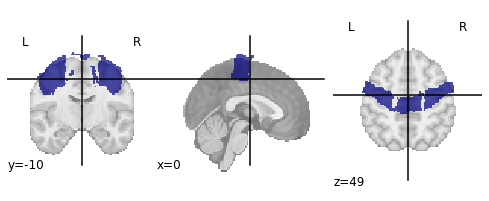

In [56]:
import numpy as np
from nilearn.image import math_img

# Find the index of the Precentral Gyrus
idx = np.where(np.array(labels) == 'Precentral Gyrus')[0]

# make it a binary region definition
region_mask =  math_img(f'i1 == {idx}', i1=atlas_filename)
plot_roi(region_mask)

In [57]:
from notip.posthoc_fmri import tdp_bound_notip_1samp
notip_bound, cluster_map = tdp_bound_notip_1samp(
    z_map,
    fmri_input,
    region_mask,
    n_permutations=200)
# remove z_map

/home/bertrandthirion/mygit/nilearn/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/home/bertrandthirion/mygit/nilearn/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


TypeError: unsupported operand type(s) for *: 'float' and 'Nifti1Image'

In [ ]:
from nilearn.plotting import plot_stat_map
plot_stat_map(cluster_map, title='TDP > {0:.2f}'.format(notip_bound))

### Using Notip on user-defined clusters

We will now use Notip on clusters extracted from the data; we seek to find connected components exceeding a z-value threshold.

In [67]:
from nilearn.regions import connected_regions
connected_regions?

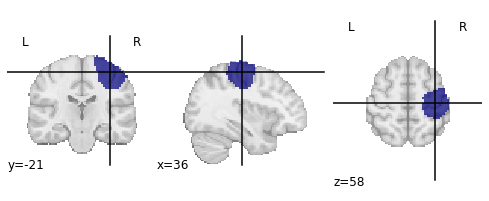

In [73]:
import numpy as np
from scipy import ndimage
from nilearn._utils.niimg import _safe_get_data
from nilearn.regions import connected_regions
from nilearn.image import binarize_img
th_img = binarize_img(z_map, 3.5)
label_map, indices = connected_regions(
    th_img,
    min_region_size=1350,
    extract_type='connected_components',
    mask_img=None)

plot_roi(index_img(label_map, 0))

cluster_mask = label_map == 1 # First cluster

# There are functions in nilearn that do that.
# 

In [ ]:
np.count_nonzero(cluster_mask)

This cluster comprises 796 voxels.

In [ ]:
from notip.posthoc_fmri import tdp_bound_notip_1samp
notip_bound, cluster_map = tdp_bound_notip_1samp(z_map, fmri_input, cluster_mask, n_permutations=200)

Let's visualize the results:

In [ ]:
from nilearn.plotting import plot_stat_map
plot_stat_map(cluster_map, title='TDP > %s' % ("{0:.2f}".format(notip_bound)))

We can also apply Notip to obtain a TDP lower bound on the 5% Benjamini-Hochberg region:

In [ ]:
# todo: use BH threshold to illustrate that FDR control does not yeld FDP control

# todo: add an example to play with alpha

# References

Blain, Alexandre, Bertrand Thirion, and Pierre Neuvial. "Notip: Non-parametric True Discovery Proportion control for brain imaging." NeuroImage 260 (2022): 119492. doi:https://doi.org/10.1016/j.neuroimage.2022.119492

Dimitri Papadopoulos Orfanos, Vincent Michel, Yannick Schwartz, Philippe Pinel, Antonio Moreno, Denis Le Bihan, and Vincent Frouin. The brainomics/localizer database. NeuroImage, 144:309–314, 2017. Data Sharing Part II. URL: https://www.sciencedirect.com/science/article/pii/S1053811915008745, doi:https://doi.org/10.1016/j.neuroimage.2015.09.052.